In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import obonet
import os
warnings.filterwarnings('ignore')

from Dataset.GoDataset import GOTermDataset, get_class_frequencies_from_dataframe
from Model.ProtienGOClassifer import ProteinGOClassifier
from Dataset.utils import prepare_data, read_fasta

/home/tan/miniconda3/envs/posetransfomer/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

BASE_PATH = "/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction"


go_graph = obonet.read_obo(os.path.join(BASE_PATH, 'Train/go-basic.obo'))
print(f"Gene Ontology graph loaded with {len(go_graph)} nodes and {len(go_graph.edges)} edges.")

train_terms_df = pd.read_csv(os.path.join(BASE_PATH, 'Train/train_terms.tsv'), sep='\\t')
print(f"Training terms loaded. Shape: {train_terms_df.shape}")


train_fasta_path = os.path.join(BASE_PATH, 'Train/train_sequences.fasta')

test_fasta_path = os.path.join(BASE_PATH, 'Test/testsuperset.fasta')

ia_df = pd.read_csv(os.path.join(BASE_PATH, 'IA.tsv'), sep='\\t', header=None, names=['term_id', 'ia_score'])
ia_map = dict(zip(ia_df['term_id'], ia_df['ia_score']))
print(train_terms_df['aspect'].value_counts().reset_index())

train_seq = read_fasta(train_fasta_path)


Gene Ontology graph loaded with 40122 nodes and 77229 edges.
Training terms loaded. Shape: (537027, 3)
  aspect   count
0      P  250805
1      C  157770
2      F  128452
[io] Read 82404 sequences from /mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/train_sequences.fasta


In [3]:
ia_df[ia_df['term_id'].isin(['GO:0000002', 'GO:0000001'])]

,term_id,ia_score
0,GO:0000001,0.000000
1,GO:0000002,2.849666


In [48]:
saved = torch.load('/mnt/d/ML/Kaggle/CAFA6/saved/best_go_model_(256).pt', weights_only=False, map_location='cpu')
model = ProteinGOClassifier(
    model_name='facebook/esm2_t6_8M_UR50D',
    num_classes=saved['model_state_dict']['classifier.3.weight'].shape[0],
    dropout=0.3,
    hidden_dim=512
)
model.load_state_dict(saved['model_state_dict'])


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [5]:
data = prepare_data(train_terms_df, train_seq, ia_df, top_k=256, test_size=0.2)


Preparing data with top 256 GO terms...
Top 256 terms selected
Frequency range: 33713 to 209
Number of valid protein entries: 70153
Label matrix shape: (70153, 256)
Average labels per protein: 3.21
Label distribution - min: 209, max: 33713
Train samples: 56122
Validation samples: 14031


In [22]:
ia_df['term_id'] = pd.Categorical(ia_df['term_id'], categories=data['top_terms'], ordered=True)

In [23]:
ia_df.sort_values('term_id')[0:len(data['top_terms'])]['ia_score'].values

array([2.01153142e-01, 9.53495736e-01, 1.42614446e+00, 3.30080925e-02,
       3.44107948e-01, 2.02729394e+00, 3.64537091e-01, 1.59569216e+00,
       2.99730532e+00, 3.12144451e+00, 1.09417391e+00, 7.04770711e-01,
       4.27239837e-02, 1.35337256e-03, 1.61066753e+00, 1.19138343e+00,
       3.76110338e-02, 1.24256517e+00, 1.13628793e-01, 5.14730750e-01,
       6.96915597e-01, 1.10746535e-03, 8.93033171e-04, 0.00000000e+00,
       2.16577944e+00, 4.25465353e-01, 4.76656260e-01, 1.30820438e+00,
       2.43698545e-03, 3.35318730e+00, 5.37116623e+00, 0.00000000e+00,
       0.00000000e+00, 1.35244586e+00, 8.24047911e-01, 1.20981425e-02,
       5.27733282e+00, 7.36079554e-01, 1.20408352e+00, 6.19230441e-01,
       1.35185312e-02, 4.93149373e-02, 1.17888875e+00, 8.65721407e-01,
       7.28254226e-01, 5.39162365e+00, 1.33595214e+00, 6.46466373e-03,
       6.42338244e-01, 6.03218318e-03, 4.03551324e-03, 0.00000000e+00,
       5.35150630e-01, 5.53718844e-01, 4.34655710e+00, 9.19501525e-01,
      

In [ ]:
data['top_terms']

['GO:0005515',
 'GO:0005634',
 'GO:0005829',
 'GO:0005886',
 'GO:0005737',
 'GO:0005739',
 'GO:0005654',
 'GO:0016020',
 'GO:0042802',
 'GO:0005576',
 'GO:0005783',
 'GO:0005615',
 'GO:0045944',
 'GO:0070062',
 'GO:0005794',
 'GO:0005730',
 'GO:0042803',
 'GO:0003723',
 'GO:0000122',
 'GO:0009507',
 'GO:0003677',
 'GO:0006355',
 'GO:0005789',
 'GO:0045893',
 'GO:0032991',
 'GO:0003700',
 'GO:0043565',
 'GO:0003729',
 'GO:0005743',
 'GO:0009536',
 'GO:0009986',
 'GO:0045892',
 'GO:0000976',
 'GO:0098978',
 'GO:0000785',
 'GO:0000978',
 'GO:0048471',
 'GO:0006357',
 'GO:0010628',
 'GO:0004674',
 'GO:0007165',
 'GO:0043025',
 'GO:0031012',
 'GO:0003735',
 'GO:0005813',
 'GO:0003682',
 'GO:0006974',
 'GO:0043066',
 'GO:0005759',
 'GO:0001228',
 'GO:0005524',
 'GO:0009506',
 'GO:0000139',
 'GO:0008284',
 'GO:0044877',
 'GO:0008270',
 'GO:0005768',
 'GO:0019901',
 'GO:0030425',
 'GO:0016324',
 'GO:0007283',
 'GO:0004672',
 'GO:0009410',
 'GO:0030424',
 'GO:0045202',
 'GO:1990837',
 'GO:00055

In [53]:
import pandas as pd

top_terms = pd.DataFrame( data['top_terms'], columns=['terms'])
top_terms.to_csv('/mnt/d/ML/Kaggle/CAFA6/saved/top_terms_256.csv', index=False)
top_terms.head()

,terms
0,GO:0005515
1,GO:0005634
2,GO:0005829
3,GO:0005886
4,GO:0005737


In [ ]:
model_name = 'facebook/esm2_t6_8M_UR50D'
top_k = 256
max_length = 256
batch_size = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("="*80)
print("GO TERM PREDICTION WITH PER-CLASS FOCAL LOSS")
print("="*80)

# Prepare data
print("\n[1/7] Preparing data...")
data = prepare_data(train_terms_df, train_seq, top_k=top_k, test_size=0.1)

class_frequencies = get_class_frequencies_from_dataframe(
    train_terms_df, data['top_terms']
)

print(f"Class frequency statistics:")
print(f"  Min: {class_frequencies.min()}")
print(f"  Max: {class_frequencies.max()}")
print(f"  Mean: {class_frequencies.mean():.1f}")
print(f"  Ratio (max/min): {class_frequencies.max() / class_frequencies.min():.1f}x")

# Compute per-class alpha

# Initialize tokenizer
print(f"\n[3/7] Loading tokenizer: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create datasets
print("\n[4/7] Creating datasets...")

val_dataset = GOTermDataset(
    data['val_sequences'],
    data['val_labels'],
    tokenizer,
    max_length=max_length
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)


GO TERM PREDICTION WITH PER-CLASS FOCAL LOSS

[1/7] Preparing data...
Preparing data with top 256 GO terms...
Top 256 terms selected
Frequency range: 33713 to 209
Number of valid protein entries: 70153
Label matrix shape: (70153, 256)
Average labels per protein: 3.21
Label distribution - min: 209, max: 33713
Train samples: 63137
Validation samples: 7016
Class frequency statistics:
  Min: 209
  Max: 33713
  Mean: 880.9
  Ratio (max/min): 161.3x

[3/7] Loading tokenizer: facebook/esm2_t6_8M_UR50D

[4/7] Creating datasets...


In [ ]:
"""Validate the model - FIXED VERSION."""
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc='Validating', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        logits = model(input_ids, attention_mask)
        
        predictions = (torch.sigmoid(logits) > 0.5).float()
        
        all_predictions.append(predictions.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# FIXED: Convert to boolean
all_predictions = np.vstack(all_predictions).astype(bool)
all_labels = np.vstack(all_labels).astype(bool)

disto = all_predictions.mean(axis=1)
print(disto.shape)

hamming_acc = (all_predictions == all_labels).all(axis=1).mean()

# FIXED: Use logical operators
tp = np.logical_and(all_predictions, all_labels).sum(axis=0)
fp = np.logical_and(all_predictions, np.logical_not(all_labels)).sum(axis=0)
fn = np.logical_and(np.logical_not(all_predictions), all_labels).sum(axis=0)

precision = tp / (tp + fp + 1e-10)
recall = tp / (tp + fn + 1e-10)
f1 = 2 * precision * recall / (precision + recall + 1e-10)

print(precision.mean())
print(recall.mean())
print(f1.mean())
#print precision, recall, f1


(7016,)
0.036331689288838426
0.017156360166055
0.014808141480313092


In [ ]:
ia_df

,term_id,ia_score
0,GO:0000001,0.000000
1,GO:0000002,2.849666
2,GO:0000011,0.137504
3,GO:0000012,6.038630
4,GO:0000017,0.514573
...,...,...
40117,GO:2001083,0.000000
40118,GO:2001084,0.000000
40119,GO:2001085,0.000000
40120,GO:2001147,6.882643


In [ ]:
hamming_acc

np.float64(0.0)

In [ ]:
precision.shape

(256,)

In [ ]:
distribution = all_predictions.mean(axis=0)
distribution = np.sort(distribution)

print(distribution[:10])
print(distribution[-10:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.00812429 0.00840935 0.00912201 0.01282782 0.01439567 0.02123717
 0.02465792 0.03506271 0.09079247 1.        ]


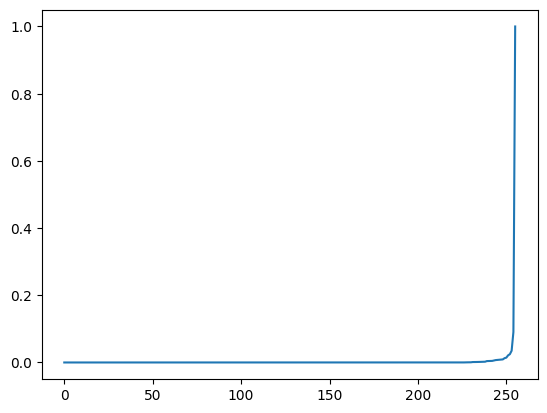

In [ ]:
import matplotlib.pyplot as plt

plt.plot(distribution)

In [ ]:
tp.sum(axis=0).shape

(256,)

In [ ]:
model = model.to(device)

# Validate
val_metrics = validate(model, val_loader, device)


print(f"Val F1: {val_metrics['f1']:.4f}")
print(f"Val Precision: {val_metrics['precision']:.4f}")
print(f"Val Recall: {val_metrics['recall']:.4f}")

[0.00390625 0.00390625 0.00390625 ... 0.00390625 0.00390625 0.00390625]
Val F1: 0.0002
Val Precision: 0.0002
Val Recall: 0.0002


In [ ]:
# test_go_classifier(
#     train_term_df=train_terms_df,
#     train_seq=train_seq,
#     model=model,
#     model_name='facebook/esm2_t6_8M_UR50D',
#     top_k=256,
#     batch_size=16,
#     max_length=512,
#     device='cuda' if torch.cuda.is_available() else 'cpu',
#     alpha_method='effective_number',
#     )